#### Year 2 Computational Challenge - Machine Learning
    Douglas Penning, Roman Ogorodnov, Manish Saharan, Ryan Hutchings
    
Overview:

We chose to break the programme into key sections, detailed by the headings shown throughout:
- Import & Preprocessing

    - Data is imported from the .csv file, with the number of duplicate and null entries counted. Removing the **23 duplicate entries** was found to improve the RMSE of the chosen model by **~0.5**. We chose to initially use **simple mean imputer** and **standard scaler** to ensure a consistent and computationally simple approach allowing each model to be tested using the same datasets.
        - A seperate file is included showing how we tested various scaler-imputer combinations


    - We chose to use an 80-20 test-train split and created the global variables **gX_train_preprocessed, gy_test etc** which are used throughout

    - **Note:** While as a group we did discuss the posibility of removing variables initially we felt that it would be a more rigourous approach to iteratively test each dropped combination and then retrain a final model using the new dataset if required. **We have also included commented out code in this cell, which when run generates a correlation matrix and heatmap (included in our word doc) and found no major multi-correlinity between variables**

- Model selection

    - We begin by defining each regression function (using a function for each allowed us to quickly individually test & efficiently pass through hyperparameters etc), using the standard parameters in *scikit-learn* and thus having the default best_params = {}. After each regressor is created the global model name dictionary is defined

    - Models were tested unoptimised, to reduce computational expense, using 3 error metrics:
        * **Root Mean Square Error** - Giving differences between actual and predicted values, with the ^2 giving greater weighting to larger errors.
        * **R^2** - Measuring correlation between datapoints, used as it is easily visually observed in the plots 
        * **Mean Absolute Average Error** - While similar to RMSE, MAE is less sensitive to larger outliers*
    - Models were then ranked on each error type (accounting for the possability for models performing better/worse in specific error types) with **Random Forrest** achieving the best score. **Note:** We have tried to ensure this code is resilient, and as such have used best_model and the model dictionary where possible in case a different dataset is better suited to a different model (though this was not possible in the optimisation section).

- Optimisation
    - We employed a **2 step optimisation process**
        1. *Randomised search* - Using a larger grid of parameters to narrow down approximate parameters
        2. *Grid search* - Using a smaller grid defined around the results of the randomised search to find the best parameter combination
    - We chose a parameter grid based on prior testing as shown in the included files
        
- Dropping variables
    - We chose to drop all possible combinations of variables using an 8 bit binary number as an index, allowing us to analyse any correlation and it's effect on model performance.

    - 2 datafiles are produced, showing the binary drop_index and errors, and a second *.xlsx* using the variable names (for single and pairs) allowing easier analysis.

- Graphing & Final data presentation
    - Comparitive graphs are shown for each regression model, allowing quick visual comparison 
    - An interactive line graph, for the chosen model, allows the user to deselect  variables to see the effect on correlation and errors quickly. This uses the gVarErrorDF meaning no extra computation is required
    - An interactive bar chart shows the effect removing individual errors has on each error metric, with a baseline shown in red

    ***To Run - Please use the Run All option to ensure dataframes are recreated and restart the terminal before re-running***

### Importing libraries
This section imports all libraries utilised within the code:
 - Misc including pandas & numpy etc.
 - scikit-learn modules
 - Graphing libraries including matplotlib, as well as ipywidgets and seaborn for interactivity/formatting

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from scipy.stats import norm
from typing import Tuple # Used for 'type hinting' in functions

# SKLearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve


# Graphing
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from ipywidgets import interact, widgets, interactive, fixed
from matplotlib.ticker import AutoMinorLocator

# Global Variables defined here to be used throughout the notebook to minimise variable scope issues
global gMethodDictionary
global gVarErrorDf
gVarErrorDf = pd.DataFrame(columns=[ 'Drop index','Predicted y', 'RMSE', 'R^2', 'MAE', 'RMSE %', 'R^2 %', 'MAE %'])
gVarNames = ['Cement','Blast Furnace Slag','Fly Ash','Water','Superplasticizer','Coarse Aggregate','Fine Aggregate','Age','Concrete compressive strength',' ']
gX_train_preprocessed = pd.DataFrame()
gX_test_preprocessed = pd.DataFrame()
gy_train = []
gy_test = []


### Data import, handling and preprocessing
 - Imports, drops duplicated rows, seperates training/target columns, completes basic preprocessing (see overview)

In [2]:
#FIXME
def csv_import() -> Tuple[pd.DataFrame, pd.Series]:
    """ 
    Import the CSV file and return the data as a pandas dataframe

    Returns:
    X: pandas dataframe
    y: pandas dataframe
    """
    #import data from the files
    dataset = pd.read_csv('Concrete_Data_Yeh_final.csv')

    # Format as a dataframe
    dataset = pd.DataFrame(dataset)
    
    #print(f'Null values: \n',dataset.isnull().sum()) #check for null values
    print(dataset.duplicated().sum(), 'duplicated rows dropped') # Prints the number of duplicated rows
    dataset = dataset.drop_duplicates() # Drop duplicates reducing RMSE by ~0.5
    dataset.dtypes #check data types
  
    # Split the data into X and y
    y = dataset["csMPa"]
    X = dataset.drop("csMPa", axis=1)
    
    # Creating a correlation matrix to see cross correlation between variables 
    correlation_matrix = X.corr()
    correlation_matrix.to_excel('correlation_matrix.xlsx')

    # Masking diagonal values corresponding to variable correlation with itself
    mask = np.ones(correlation_matrix.shape, dtype=bool)
    np.fill_diagonal(mask, False)

    # Checking for significant correlations in off-diagonal elements
    if (abs(correlation_matrix.where(mask)) > 0.9).any().any():
        print('One or more variables have significant intercorrelation')
    else:
        print('No significant intercorrelation between variables')

    # Plot the correlation matrix - Commented out as not needed in final run
    #plt.figure(figsize=(10,10))
    #sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
    #plt.show()

    return X, y

In [3]:
def preprocessing(X:pd.DataFrame, y: pd.Series) -> None:
    """ 
    Preprocess the data (simple imputer (mean), standard scaler) and split into training and test sets

    Parameters:
    X (pd.DataFrame): The feature variables
    y (pd.Series): The target variable (concrete compressive strength)
    
    Returns: None (global variables are set)
    """
    # Splitting the data into training and test sets
    global gX_train_preprocessed, gX_test_preprocessed
    global gy_train, gy_test    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Creating a preprocessing pipeline that imputes missing values with the mean and scales the data
    preprocessing_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    # Setting the global variables
    gX_train_preprocessed = pd.DataFrame(preprocessing_pipeline.fit_transform(X_train), columns=X_train.columns)
    gX_test_preprocessed = pd.DataFrame(preprocessing_pipeline.transform(X_test), columns=X_test.columns)
    gy_train = y_train
    gy_test = y_test

### Regression functions

This section defines functions for various regression models which are later compared to choose the most effective model.

The regression models included are:

1. **Linear Regression (`linear_regression`)**: While it is stated that data is nonlinear we used it as a baseline.

2. **Decision Tree Regression (`decision_tree_regression`)**

3. **Random Forest Regression (`random_forest_regression`)**: **Chosen model**

4. **Lasso Regression (`lasso_regression`)**

5. **Elastic Net Regression (`elastic_net_regression`)**

6. **Ridge Regression (`ridge_regression`)**

7. **Support Vector Regression (`svr_regression`)**

8. **K-Nearest Neighbors Regression (`knn_regression`)**



In [4]:
def linear_regression(xTrainData: pd.DataFrame, yTrainData: pd.DataFrame, yTestData: pd.Series, bestFit = {}) -> np.ndarray:
    """
    This function creates and fits a linear regression model

    Parameters:
    xTrainData (numpy.ndarray or pandas.DataFrame): The independent variables for training
    yTrainData (numpy.ndarray or pandas.Series): Target training values (Compressive Strength)
    yTestData (numpy.ndarray or pandas.DataFrame): The independent variables for the test set, used to predict y_pred
    bestFit (dict, optional): The parameters for the Linear Regression model. Defaults to an empty dictionary.

    Returns:
    y_pred (numpy.ndarray): The predicted values of compressive strength for the test set
    """ 
   
    regressor = LinearRegression(**bestFit) # Creating the Linear Regression model
    regressor.fit(xTrainData, yTrainData) # Fitting the data
    y_pred = regressor.predict(yTestData) # Making predictions

    return y_pred

In [5]:
def decision_tree_regression(xTrainData: pd.DataFrame, yTrainData: pd.DataFrame, yTestData: pd.Series, bestFit = {}) -> np.ndarray:
    """
    This function creates and fits a decision tree regression model

    Parameters:
    xTrainData (numpy.ndarray or pandas.DataFrame): The independent variables for training
    yTrainData (numpy.ndarray or pandas.Series): Target training values (Compressive Strength)
    yTestData (numpy.ndarray or pandas.DataFrame): The independent variables for the test set, used to predict y_pred
    bestFit (dict, optional): The parameters for the Linear Regression model. Defaults to an empty dictionary.

    Returns:
    y_pred (numpy.ndarray): The predicted values of compressive strength for the test set
    """ 

    regressor = DecisionTreeRegressor(**bestFit) # Creating the Decision Tree regressor
    regressor.fit(xTrainData, yTrainData)
    y_pred = regressor.predict(yTestData)
    
    return y_pred

In [6]:
def random_forest_regression(xTrainData: pd.DataFrame, yTrainData: pd.DataFrame, yTestData: pd.Series, bestFit = {})-> np.ndarray:
    """
    This function creates and fits a random forest regression model

    Parameters:
    xTrainData (numpy.ndarray or pandas.DataFrame): The independent variables for training
    yTrainData (numpy.ndarray or pandas.Series): Target training values (Compressive Strength)
    yTestData (numpy.ndarray or pandas.DataFrame): The independent variables for the test set, used to predict y_pred
    bestFit (dict, optional): The parameters for the Linear Regression model. Defaults to an empty dictionary.

    Returns:
    y_pred (numpy.ndarray): The predicted values of compressive strength for the test set
    """ 
   
    regressor = RandomForestRegressor(**bestFit) # Creating the Random Forest Regressor
    regressor.fit(xTrainData, yTrainData) 
    y_pred = regressor.predict(yTestData)

    return y_pred

In [7]:
def perform_lasso(xTrainData: pd.DataFrame, yTrainData: pd.DataFrame, yTestData: pd.Series, bestFit = {}) -> np.ndarray:
    """
    This function creates and fits a Lasso regression model

    Parameters:
    xTrainData (numpy.ndarray or pandas.DataFrame): The independent variables for training
    yTrainData (numpy.ndarray or pandas.Series): Target training values (Compressive Strength)
    yTestData (numpy.ndarray or pandas.DataFrame): The independent variables for the test set, used to predict y_pred
    bestFit (dict, optional): The parameters for the Linear Regression model. Defaults to an empty dictionary.

    Returns:
    y_pred (numpy.ndarray): The predicted values of compressive strength for the test set
    """ 
    
    model = Lasso(**bestFit) # Create and train the model
    model.fit(xTrainData, yTrainData)
    y_pred = model.predict(yTestData)
    
    return y_pred

In [8]:
def elastic_net_regression(xTrainData: pd.DataFrame, yTrainData: pd.DataFrame, yTestData: pd.Series, bestFit = {}) -> np.ndarray:
    """
    This function creates and fits a elastic net regression model

    Parameters:
    xTrainData (numpy.ndarray or pandas.DataFrame): The independent variables for training
    yTrainData (numpy.ndarray or pandas.Series): Target training values (Compressive Strength)
    yTestData (numpy.ndarray or pandas.DataFrame): The independent variables for the test set, used to predict y_pred
    bestFit (dict, optional): The parameters for the Linear Regression model. Defaults to an empty dictionary.

    Returns:
    y_pred (numpy.ndarray): The predicted values of compressive strength for the test set
    """ 

    regressor = ElasticNet(**bestFit)    # Creating the Elastic Net Regressor
    regressor.fit(xTrainData, yTrainData)
    y_pred = regressor.predict(yTestData)

    return y_pred

In [9]:
def ridge_regression(xTrainData: pd.DataFrame, yTrainData: pd.DataFrame, yTestData: pd.Series, bestFit = {}) -> np.ndarray:
    """
    This function creates and fits a ridge regression model

    Parameters:
    xTrainData (numpy.ndarray or pandas.DataFrame): The independent variables for training
    yTrainData (numpy.ndarray or pandas.Series): Target training values (Compressive Strength)
    yTestData (numpy.ndarray or pandas.DataFrame): The independent variables for the test set, used to predict y_pred
    bestFit (dict, optional): The parameters for the Linear Regression model. Defaults to an empty dictionary.

    Returns:
    y_pred (numpy.ndarray): The predicted values of compressive strength for the test set
    """ 

    regressor = Ridge(**bestFit) # Creating the Ridge Regressor
    regressor.fit(xTrainData, yTrainData)
    y_pred = regressor.predict(yTestData)

    return y_pred

In [10]:
def perform_svr(xTrainData: pd.DataFrame, yTrainData: pd.DataFrame, yTestData: pd.Series, bestFit = {}) -> np.ndarray:
    """
    This function creates and fits a support vector regression model

    Parameters:
    xTrainData (numpy.ndarray or pandas.DataFrame): The independent variables for training
    yTrainData (numpy.ndarray or pandas.Series): Target training values (Compressive Strength)
    yTestData (numpy.ndarray or pandas.DataFrame): The independent variables for the test set, used to predict y_pred
    bestFit (dict, optional): The parameters for the Linear Regression model. Defaults to an empty dictionary.

    Returns:
    y_pred (numpy.ndarray): The predicted values of compressive strength for the test set
    """ 
   
    model = SVR(**bestFit)  # Create and train the model
    model.fit(xTrainData, yTrainData)
    y_pred = model.predict(yTestData)

    return y_pred

In [11]:
def perform_knn(xTrainData: pd.DataFrame, yTrainData: pd.DataFrame, yTestData: pd.Series, bestFit = {})-> np.ndarray:
    """
    This function creates and fits a KNN regression model

    Parameters:
    xTrainData (numpy.ndarray or pandas.DataFrame): The independent variables for training
    yTrainData (numpy.ndarray or pandas.Series): Target training values (Compressive Strength)
    yTestData (numpy.ndarray or pandas.DataFrame): The independent variables for the test set, used to predict y_pred
    bestFit (dict, optional): The parameters for the Linear Regression model. Defaults to an empty dictionary.

    Returns:
    y_pred (numpy.ndarray): The predicted values of compressive strength for the test set
    """ 

    model = KNeighborsRegressor(**bestFit)    # Create and train the model
    model.fit(xTrainData, yTrainData)
    y_pred = model.predict(yTestData)
    
    return y_pred

In [12]:
# Defines a dictionary containing Name:Function pairs for each regression method
gMethodDictionary = [('Linear Regression', linear_regression),
                    ('Decision Tree Regression', decision_tree_regression),
                    ('Random Forest Regression', random_forest_regression),
                    ('Ridge', ridge_regression), 
                    ('Lasso', perform_lasso),
                    ('Elastic Net', elastic_net_regression),
                    ('Support Vector Regression', perform_svr),
                    ('K-Nearest Neighbors Regression', perform_knn)]

### Model Evaluation

- Analysing the performance of each regression model to determine which technique most accuratley predicts compressive strength
- Uses metrics:
    1) Root Mean Square Error
    2) R^2
    3) Mean Absolute Error
- Models are ranked on **ALL** metrics to find the best model (though it was observed ranking was consistent across all metrics at this stage)
- Dataframe exported to Excel for review
    

    

In [13]:
def regression_performance() -> Tuple[str, pd.DataFrame]:
    """
    This function evaluates the performance of all regression models defined, iterating through the global `gMethodDictionary`.
    Predicted values are used to calculate the root mean squared error (RMSE), R^2 score, and mean absolute error (MAE).
    The results are stored in a DataFrame.

    Models are ranked based on each performance metric, with the highest R^2 score and the lowest 
    RMSE and MAE being the best. "rank sum" is calculated for each model with the model with the lowest selected.

    Parameters: None

    Returns:
    best_model (str): The name of the best model.
    df (pd.DataFrame): A DataFrame containing the performance metrics and ranks for each model.
    """
    
    data = []
    for model_name, model in gMethodDictionary: # Loop over each model
        # Calling each regression model, passing in the training and test data (Note: models are unoptimised so bestFit assumes default parameters))      
        y_pred = model(gX_train_preprocessed, gy_train, gX_test_preprocessed)

        # Calculate the performance metrics
        rmse = sqrt(mean_squared_error(gy_test, y_pred))
        r2 = r2_score(gy_test, y_pred)
        mae = mean_absolute_error(gy_test, y_pred)
    
        # Append the data to the list
        data.append([model_name, y_pred, rmse, r2, mae])

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['Model', 'y_pred', 'RMSE', 'R^2','MAE'])

    # Set the model names as the index
    df.set_index('Model', inplace=True)

    # Rank each metric, with the highest being the best for R^2 and the lowest being the best for RMSE and MAE
    df['R^2_rank'] = df['R^2'].rank(ascending=False)
    df['RMSE_rank'] = df['RMSE'].rank()
    df['MAE_rank'] = df['MAE'].rank()

    
    df['rank_sum'] = df['R^2_rank'] + df['RMSE_rank'] + df['MAE_rank'] # Calculate the sum of the ranks

    df.to_excel('regression_performance.xlsx') # Exporting the dataframe to excel

    # Find the model with the lowest rank sum
    best_model = df['rank_sum'].idxmin()

    return best_model, df

### Hyperparameters

As shown Random Forrest Regression has the best untuned performance on our dataset and as such we are only analysing hyperparameters for this model:
The most important hyperparameters to tune in a Random Forest model to improve its performance are:

1. `n_estimators`: Higher number of trees give you better performance but is more computationally intense.

2. `max_depth`: Can help to prevent overfitting. If the max depth is too high, the model may learn too much from the training data and perform poorly on test data.

3. `min_samples_split`: Increasing this parameter increases the number of samples considered at each node.

4. `min_samples_leaf`: Similar to min_samples_splits, instead describing the minimum number of samples of samples at the leafs

5. `max_features`: The number of features to consider when looking for the best split. When using "auto", `max_features=sqrt(n_features)`.

6. `bootstrap`: If False, the whole dataset is used to build each tree. We chose to only use False throught as preforming initial testing found true to yield significantly lower performance

We chose to test these along with minimum impurity decrease.

**Random Search** sets up a grid of hyperparameter values and selects random combinations and is therefore less computationally expensive then Grid Search (and was found to be better optimised for multi-core processing). We use this step first, as while efficient it's not guaranteed to find the best parameters.

**Grid Search** systematically works through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance. We use a smaller grid defined around the results of the random search.

In [14]:
def random_grid_search()-> dict:
    """
    This function performs a randomised search to narrow down the hyperparameter grid for the Random Forest Regressor.
    It then performs a grid search based on the randomised search results, to find the best hyperparameter combination.

    Parameters: None
    Returns: best_grid_params (dict): The best hyperparameter combination
    """
    ### Included parameters were selected based on the results of the of several larger tests, one of which is seen in the appendix of the report and Code_hyperparameters
    ### We made use of several large grid search runs lasting over 12 hours and were able to achieve the best results with parameters covered in the grids below
    ### {'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 160} - Gave the best results observed
    ### RMSE = 3.986254, R^2 = 0.931, MAE = 2.975 before removing damaging variables

    ### NOTE: To decrease runtime, the number of iterations for the randomised search has been reduced to 450 potentially harming the results.


    # Define a hyperparameter grid for randomised search
    param_random = {
        'n_estimators': [50, 100, 125, 135, 145, 155, 170], # 7
        'max_depth': [None, 20, 30, 40], #4
        'min_samples_split': [ 2, 3, 5, 10], #4
        'min_samples_leaf': [ 1, 2, 5, 10],#4
        'min_impurity_decrease': [0.0, 0.2, 0.4, 0.5],#4
        'bootstrap': [False], #1
        'max_features': ['auto', 'sqrt'] #2
    }

    # Perform randomised search over the larger parameter grid (verbose specifies how much information is displayed)
    rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_random, n_iter=450, cv=5, n_jobs=-1, verbose=0)
    rf_random.fit(gX_train_preprocessed, gy_train)

    # Identify the best hyperparameter combination from random search
    best_random_params = rf_random.best_params_

    # Define a narrower hyperparameter grid around the best hyperparameter combination (if statements used to ensure values are not out of range)
    param_grid = {
        'n_estimators': [best_random_params['n_estimators'] - 10, best_random_params['n_estimators'], best_random_params['n_estimators'] + 10],
        'min_samples_split': [best_random_params['min_samples_split'] - 1 if best_random_params['min_samples_split'] > 2 else 2, best_random_params['min_samples_split'], best_random_params['min_samples_split'] + 1],
        'min_samples_leaf': [best_random_params['min_samples_leaf'] - 1 if best_random_params['min_samples_leaf'] > 1 else 2, best_random_params['min_samples_leaf'], best_random_params['min_samples_leaf'] + 1],
        'min_impurity_decrease': [best_random_params['min_impurity_decrease'] - 0.1 if best_random_params['min_impurity_decrease'] > 0.1 else 0, best_random_params['min_impurity_decrease'], best_random_params['min_impurity_decrease'] + 0.1],
        'bootstrap': [best_random_params['bootstrap']],
        'max_features': [best_random_params['max_features']]
    }
    # If the best max_depth is None, then only test None, otherwise test the best value +/- 5 
    if best_random_params['max_depth'] == None:
        param_grid['max_depth'] = [None]
    else:
        param_grid['max_depth'] = [best_random_params['max_depth'] - 5, best_random_params['max_depth'], best_random_params['max_depth'] + 5]

    # Perform grid search
    rf_grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
    rf_grid.fit(gX_train_preprocessed, gy_train)

    # Identify the best hyperparameter combination from grid search
    best_grid_params = rf_grid.best_params_

    # Use the best hyperparameter combination to train the final Random Forest model
    final_rf_model = RandomForestRegressor(**best_grid_params)
    final_rf_model.fit(gX_train_preprocessed, gy_train)

    return best_grid_params

In [15]:
def opt_unopt_random_forest(best_grid_params: dict) -> dict:
    """
    This function compares the performance of the original unoptimised Random Forest Regressor model with the optimised Random Forest Regressor model.
    The model trained, using the hyperparameter combination identified by the grid search, performance metrics are compared to the original model. If the
    optimised model performs worse than the original model, the grid search is deemed unsuccessful and an empty dictionary is returned.

    Parameters: 
    best_grid_params (dict): The best hyperparameter combination from the grid search.
    
    Returns:
    best_grid_params (dict): The best hyperparameter combination in case the optimisation was unsuccessful.
    """ 
    # Original unoptimised Random Forest Regression
    y_pred_unoptimised = random_forest_regression(gX_train_preprocessed, gy_train, gX_test_preprocessed)

    # Optimized Random Forest Regression  
    y_pred_optimised = random_forest_regression(gX_train_preprocessed, gy_train, gX_test_preprocessed,best_grid_params)

    # Calculate errors
    rmse_unoptimised = sqrt(mean_squared_error(gy_test, y_pred_unoptimised))
    rmse_optimised = sqrt(mean_squared_error(gy_test, y_pred_optimised))
    r2_unoptimised = r2_score(gy_test, y_pred_unoptimised)
    r2_optimised = r2_score(gy_test, y_pred_optimised)
    mae_unoptimised = mean_absolute_error(gy_test, y_pred_unoptimised)
    mae_optimised = mean_absolute_error(gy_test, y_pred_optimised)

    # Print errors
    print("Unoptimised RMSE:", rmse_unoptimised)
    print("Optimised RMSE:", rmse_optimised)
    print("Unoptimised R^2:", r2_unoptimised)
    print("Optimised R^2:", r2_optimised)
    print("Unoptimised MAE:", mae_unoptimised)
    print("Optimised MAE:", mae_optimised)

    if rmse_optimised > rmse_unoptimised:
        print("Optimisation unsuccessful")
        best_grid_params = {}
    return best_grid_params

### Dropping variables

    var_drop():
Used to create a new data set, dropping all combinations of variables using a binary 'drop index'. This allows us to determine the effect on regression performance when dropping single, pairs, triplets or any other combination of variables. This was chosen to allow us to clearly see and account for variable correlation, and efficiently plot the interactive graphs as shown.

    var_performance():
Taking the dataset from var_drop(): to measure the performance effect of dropping variables

    var_impact_pct():
Calculating the difference in original vs retrained performance for various combinations

In [16]:
def var_drop(dropVar: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Drops columns from the training and testing datasets based on a binary number.
    Each digit in the binary number corresponds to a column in the datasets. If the digit is 1, the corresponding column is dropped. If the digit is 0, the corresponding column is kept.

    Parameters:
    dropVar (int): An intiger, converted to binary with each digit representing a column in the datasets.

    Returns:
    datasetTrain_drop (pd.DataFrame): The training dataset with the columns dropped.
    datasetTest_drop (pd.DataFrame): The testing dataset with the columns dropped.
    """

    # Convert the binary number to a list of booleans
    bool_list = [bool(int(x)) for x in format(dropVar, '0{}b'.format(len(gX_train_preprocessed.columns)))]

    # Create a list of column names to drop based on the boolean list
    columns_to_drop_train = gX_train_preprocessed.columns[bool_list]
    columns_to_drop_test = gX_test_preprocessed.columns[bool_list]

    # Drop the columns
    datasetTrain_drop = gX_train_preprocessed.drop(columns_to_drop_train, axis=1)
    datasetTest_drop = gX_test_preprocessed.drop(columns_to_drop_test, axis=1)

    return datasetTrain_drop, datasetTest_drop

In [17]:
def var_performance(best_grid_params: dict, best_model: str) -> None:
    """
    This function evaluates the performance of the best regression model for every combination of dropped variables.
    best_model is used to identify the best regression model (ensuring resiliance to changes in the gMethodDictionary)

    It then loops over all variables in the preprocessed training and testing data, dropping one variable at a time 
    and evaluating the performance of the model without that variable. 

    The function also calculates the variation of each performance metric compared to the base case (i.e., when no 
    variables are dropped). The results are stored in the global DataFrame `gVarErrorDf`.

    Parameters:
    best_grid_params (dict): The best hyperparameter combination as found by the optimisation function.
    best_model (str): The name of the best regression model.
    
    Returns:    None
    """
    x_train_drop = gX_train_preprocessed.copy()
    x_test_drop = gX_test_preprocessed.copy()


    for key, model_function in gMethodDictionary:
        if key == best_model:
            break

    for i in range(255):
        x_train_drop, x_test_drop = var_drop(i)
       
        y_pred = model_function(x_train_drop, gy_train, x_test_drop, best_grid_params)
        rms_error = sqrt(mean_squared_error(gy_test, y_pred))
        r2_error = r2_score(gy_test, y_pred)
        ma_error = mean_absolute_error(gy_test, y_pred)
        if i == 0:
            rms_var = 1
            r2_var = 1
            ma_var = 1
            rms_base = rms_error
            r2_base = r2_error
            ma_base = ma_error

        else:
            rms_var = rms_error / rms_base
            r2_var = r2_error / r2_base
            ma_var = ma_error / ma_base


        gVarErrorDf.loc[i] = [bin(i), y_pred, rms_error, r2_error, ma_error, rms_var, r2_var, ma_var]

In [18]:
def var_impact_pct() -> pd.DataFrame:
    """
    This function calculates the impact of each variable on the model's performance metrics (RMSE, R^2, and MAE) 
    when the variable is dropped. A DataFrame is created containing performance metrics each singl/ double variable
    drop. 

    The function then ranks each model  based on the performance metrics, 
    calculates a rank sum for each model, and sorts the DataFrame by the rank sum. The model with the lowest rank 
    sum is considered the best model.
    The sorted DataFrame is then exported to an excel file.

    Parameters: None

    Returns: impact_df (pd.DataFrame): A DataFrame containing the performance metrics for each model.
    """

    impact_df = pd.DataFrame(columns=['Dropped variable: 1','Dropped variable : 2', 'RMSE', 'R^2', 'MAE','RMSE %', 'R^2 %', 'MAE %', ])

    # NOTE: Single variable impact
    for i in range(8):
        index = 2**i
        impact_df.loc[i] = [gVarNames[(7-i)],gVarNames[9], gVarErrorDf.loc[index]['RMSE'], gVarErrorDf.loc[index]['R^2'], gVarErrorDf.loc[index]['MAE'], gVarErrorDf.loc[index]['RMSE %'], gVarErrorDf.loc[index]['R^2 %'], gVarErrorDf.loc[index]['MAE %']]
    
    #Data frame containing all single variable impacts
    impact_df.loc[8] = ["None dropped",'', gVarErrorDf.loc[0]['RMSE'], gVarErrorDf.loc[0]['R^2'], gVarErrorDf.loc[0]['MAE'], gVarErrorDf.loc[0]['RMSE %'], gVarErrorDf.loc[0]['R^2 %'], gVarErrorDf.loc[0]['MAE %']] 
    
    # NOTE: Double variable impact
    l = 9
    for j in range(7):
        #loop from j+1 to 8
        for k in range(j+1,8):
            if j != k:
                index = 2**j + 2**k #7- index to move through gVarNames correctly
                # Data frame containing all double variable impacts
                impact_df.loc[l] = [gVarNames[(7-j)], gVarNames[(7-k)], gVarErrorDf.loc[index]['RMSE'], gVarErrorDf.loc[index]['R^2'], gVarErrorDf.loc[index]['MAE'], gVarErrorDf.loc[index]['RMSE %'], gVarErrorDf.loc[index]['R^2 %'], gVarErrorDf.loc[index]['MAE %']]
                l += 1

    # Rank each metric, with the highest being the best for R^2 and the lowest being the best for RMSE and MAE
    impact_df['R^2_rank'] = impact_df['R^2'].rank(ascending=False)
    impact_df['RMSE_rank'] = impact_df['RMSE'].rank()
    impact_df['MAE_rank'] = impact_df['MAE'].rank()

    # Calculate the sum of the ranks
    impact_df['rank_sum'] = impact_df['R^2_rank'] + impact_df['RMSE_rank'] + impact_df['MAE_rank']

    # Find the model with the lowest rank sum
    best_model = impact_df['rank_sum'].idxmin()
    
    impact_df.sort_values(by=['rank_sum'], inplace=True) # Sort the data frame based on the rank sum
    impact_df.to_excel('variable_drop_impact.xlsx')#export to excel
    return impact_df

### Final Predictions
    
Using all information gathered to create a retrained model (Found to be Random Forrest Regression) removing variables found to harm performance. Hyperparameters are re-optimised for this new data set. Results are displayed

In [19]:
def var_drop_final()-> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Drops columns from the training and testing datasets based on the binary number with the lowest RMSE.
    The function first sorts the global DataFrame `gVarErrorDf`, to find the drop index with the lowest errors.
    The function then creates copies of the global DataFrames `gX_train_preprocessed` and `gX_test_preprocessed`, and drops the specified columns from these copies.

    Parameters: None

    Returns:
    X_train_final (pd.DataFrame): The training dataset with the columns dropped.
    X_test_final (pd.DataFrame): The testing dataset with the columns dropped.
    """
    #sort gVarError by RMSE to determine which index to use
    varError_sort = gVarErrorDf.sort_values(by=['RMSE'], ascending = True,  inplace=False)
    drop_string = varError_sort['Drop index'].iloc[0]

    # Convert the binary number to a list of booleans
    bool_list = [bool(int(x)) for x in drop_string[2:]]
    #bool list needs to be made up to 8 digits
    while len(bool_list) < 8:
        bool_list.insert(0, False)
    
    # Creates a copy of gX_train_preprocessed etc and drops the columns
    X_train_final = gX_train_preprocessed.copy()
    X_test_final = gX_test_preprocessed.copy()
    columns_to_drop = gX_train_preprocessed.columns[bool_list]

    #print out the names of the columns to drop
    print('Dropped variables:', columns_to_drop.tolist())

    X_train_final.drop(columns_to_drop, axis=1, inplace=True)
    X_test_final.drop(columns_to_drop, axis=1, inplace=True)

    return X_train_final, X_test_final

In [20]:
# FIXME
def final_hyperparameters(finalX_train: pd.DataFrame, finalX_test: pd.DataFrame) -> Tuple[dict, np.ndarray]:
    """
    Rerunning hyperparameter optimisation as dropping variables may change the best hyperparameter combination.

    Parameters:
    finalX_train (pd.DataFrame): The training dataset with the columns dropped.
    finalX_test (pd.DataFrame): The testing dataset with the columns dropped.

    Returns:
    final_grid_params (dict): The best hyperparameter combination.
    y_pred_final (np.ndarray): The predicted values of compressive strength for the test set.
    """

    # Retrain hyperparameters
    param_grid = {
        'n_estimators': [150, 155, 160],
        'max_depth': [25, 30, 35],
        'min_samples_split': [2, 3, 4],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [False]}

    rf_grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, verbose = 0)
    rf_grid.fit(finalX_train, gy_train)

    final_grid_params = rf_grid.best_params_

    #Final model
    y_pred_final = random_forest_regression(finalX_train, gy_train, finalX_test, final_grid_params)

    # Calculate errors
    rmse_final = sqrt(mean_squared_error(gy_test, y_pred_final))
    r2_final = r2_score(gy_test, y_pred_final)
    mae_final = mean_absolute_error(gy_test, y_pred_final)

    # Print errors
    print("Final RMSE:", rmse_final)
    print("Final R^2:", r2_final)
    print("Final MAE:", mae_final)

    return final_grid_params, y_pred_final

In [21]:
def final_error_analysis( y_pred_final: np.ndarray) -> None:
    """
    Calculates the mean error, standard deviation of errors, and 95% confidence interval of errors in the final model's predictions.
    Metrics are printed.

    Parameters:
    y_pred_final (np.ndarray): The predicted values from the final model.

    Returns: None
    """
    
    # calculates uncertainties in the final model's predictions
    prediction_errors = gy_test - y_pred_final
    mean_error = np.mean(prediction_errors)
    std_dev_error = np.std(prediction_errors)
    conf_interval_error = np.percentile(prediction_errors, [2.5, 97.5])

    print(f"Mean error: {round(mean_error,5)} CsMPa (5 decimal places)")
    print(f"Standard deviation of errors: {round(std_dev_error,5)} CsMPa (5 decimal places)")
    print(f"95% confidence interval of errors: {conf_interval_error} CsMPa")

    # calculates the percentage of predictions that are within 10% of the actual values
    within_10_percent = np.abs(prediction_errors) < 0.1 * gy_test
    percentage_within_10 = np.mean(within_10_percent)

    print(f"Percentage of predictions that are within 10% of the actual values: {round(percentage_within_10*100,2)} %")

### Graph Functions

1. `comp_graph()` - *Static*

    This function creates subplots allowing visual comparison between all regression functions.

2. `var_effect_line()` - *Interactive*

    This function is used to visualise the effect of a variable on the outcome. The user can choose any combination of variables to drop by deselecting a checkbox, the graph shows predicted vs actual values of Compressive strength, and the error metrics are shown rounded to 4 decimal places.

3. `var_effect_bar()` - *Interactive*

    This function is used to create a bar chart showing the effect on the various errors, of removing individual variables from the dataset. Users can choose the error type from the drop down menu.

4. `plot_learning_curve()` - *Static*

    This graph is run as part of our *Final_run()* and shows the learning curves for the final optimised model, using a dataset dropping variables found to harm performance compared to the unoptimised Ranom Forrest Model. It shows how the amount of training data effects model errors.

5. `error_histogram()` - *Interactive*

    This interactive histogram shows the error distribution for the final model (approximating a normal distribution) providing crucial infromation when analysing the reliability of predictions. Bar width can be altered by the user with the slider.

6. `visualize_rf_trees` - *Static*

    **Not run** but included to show the growth of the "random forrest"


In [22]:
def comp_graph() -> None:
    """
    This function generates a comparative graph of actual vs predicted values for different regression models.

    The function calls the `regression_performance` function to get the best model and a DataFrame containing 
    the predictions of each model. It then creates a scatter plot for each model, comparing the actual and 
    predicted values. The scatter plots are arranged in a grid, with one subplot for each model with a y=x line added.

    The function doesn't return anything. The graph is displayed using `plt.show()`.

    Note: This function relies on the global variable `gy_test` for the actual values. Make sure this variable 
    is defined and properly initialized before calling this function.

    Parameters: None
    Returns: None
    """
    # Number of models taking the data from the data frame in the regression performance function
    best_model, df = regression_performance()
    n_models = len(df)

    # Create a figure and axes with a subplot for each model
    fig, axs = plt.subplots(2, 4, figsize=(20, 15))

    # Flatten the axes array
    axs = axs.flatten()

    # Loop over each model
    for i, (model_name, row) in enumerate(df.iterrows()):         # Plot y_test vs y_pred
        axs[i].scatter(gy_test, row['y_pred'], s=10)
        axs[i].plot([gy_test.min(), gy_test.max()], [gy_test.min(), gy_test.max()], 'k--', lw=2)
        axs[i].set_xlabel('Actual CsMPa', fontsize=12)
        axs[i].set_ylabel('Predicted CsMPa', fontsize=12)
        axs[i].set_title(f'{model_name}')
        axs[i].xaxis.set_minor_locator(AutoMinorLocator())
        axs[i].yaxis.set_minor_locator(AutoMinorLocator())
        axs[i].grid(False)

    # Remove unused subplots
    for i in range(n_models, len(axs)):
        fig.delaxes(axs[i])

    # Add overall figure title
    fig.suptitle('Comparative Graph of Actual vs Predicted Values of Compressive Strength (CsMPa) \n (y=x line added for reference) \n', fontsize=15)
    
    plt.tight_layout()
    plt.show()

In [23]:
def var_effect_line() -> None:
    """ 
    This function creates an interactive scatter plot of actual vs predicted values for the best model, with a trendline.
    Checkboxes are added to the plot, allowing the user to remove variables from the model. The plot is updated when the user clicks a checkbox.
    A text box is added to the plot, containing the effect of removing each variable on the error metrics.

    Parameters: None
    Returns: None (The plot is displayed using `plt.show()`)
    """

    # Create a list of checkboxes, taking the variable names from the global variable `gVarNames`
    checkboxes = [widgets.Checkbox(value=True, description=var) for var in gVarNames[0:8]]

    def update_lines(*args, **kwargs):
        """
        This function updates the scatter plot when the user clicks a checkbox.

        Parameters:
        *args: A list of arguments. The first argument is a boolean value indicating whether the checkbox is checked.
        **kwargs: A dictionary of keyword arguments. The key is the name of the checkbox, and the value is a boolean indicating whether the checkbox is checked.

        Returns: None
        """
        active_vars = [var.description for var in checkboxes if var.value] # Get the names of the active variables
        # Checks that at least one checkbox (variable) is selected, if not an error is printed and the function returns
        if not active_vars:
            print("Error: At least one checkbox must be selected.")
            return
        
        clear_output(wait=True) # Clear the output of the cell
        #sns.set_style("whitegrid") # Set the style of the plot
        
        fig, ax = plt.subplots(figsize=(10, 6)) # Create a figure and axes
        plt.size=(10, 6)

        fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)  # Center the plot
        active_vars = [var.description for var in checkboxes if var.value]
        binary_string = ''.join(['1' if not checkbox.value else '0' for checkbox in checkboxes]) # Create a binary string representing the active variables
        print(f'Drop Index: {binary_string}')
        binary_int = int(binary_string,2)

        x = gy_test
        y = gVarErrorDf.loc[(binary_int)].iloc[1] # Using the binary string to select the correct row in the global DataFrame `gVarErrorDf`
        ax.scatter(x, y, label='Data')  # Add a label to the scatter plot
        
        # Fit a line to the data
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        
        # Add the line to the plot
        ax.plot(x, p(x), "r--", label='Trendline')  # Add a label to the trendline
        
        plt.xticks(fontsize=14)  # Increase the size of the x-axis labels
        plt.yticks(fontsize=14)  # Increase the size of the y-axis labels
        
        # Add titles & axis titles
        plt.title('Scatter plot of test against predicted values of \n compressive strength (CsMPa) ', fontsize=16) 
        plt.xlabel('Actual CsMPa', fontsize=14)
        plt.ylabel('Predicted CsMPa', fontsize=14)

        # Add legend
        plt.legend(bbox_to_anchor=(0.95, 0.2))
      
        ax = plt.gca() # Set ax = the current axes
        plt.minorticks_on()
        ax.grid(False)
        
        
        # Adding a text box containing each error metric rounded to 4 decimal places
        rmse = round(gVarErrorDf.loc[binary_int].iloc[2], 4)
        r2 = round(gVarErrorDf.loc[binary_int].iloc[3], 4)
        mae = round(gVarErrorDf.loc[binary_int].iloc[4], 4)
        
        text_box = f'RMSE = {rmse}\nR^2 = {r2}\nMAE = {mae}'
        plt.text(0.05, 0.95, text_box, transform=ax.transAxes, verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        
        textstr ='''
This scatter plot shows the relationship between the actual and 
predicted values of Compressive Strength. A trendline is shown in red. 

Each point on the plot represents a data point. The position of
a point on the x-axis represents its actual value, and the position on 
the y-axis represents its predicted value. Error metrics (4 dp.) are shown in a text box 
at the top left. 

Use the checkboxes to remove variables from the model, the plot will update and allow you
to visualise the effect of removing combinations of variables on the error metrics.
        '''
        
        # Add a text box containing the description of the plot
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        
        plt.show()
        

    # Grid of checkboxes in a 4x2 grid
    grid = [
        [checkboxes[i] for i in range(j, j+4)]
        for j in range(0, 8, 4)
    ]

    grid = [[checkboxes[i] for i in range(j, j + 4)] for j in range(0, 8, 4)]
    ui = widgets.VBox([widgets.HBox(row) for row in grid])
    out = widgets.interactive_output(update_lines, {checkbox.description: checkbox for checkbox in checkboxes})

    display(ui, out)

In [24]:
def var_effect_bar() -> None:
    """
    This function generates an interactive bar chart, showing the effect of removing each variable on the performance metrics (RMSE, R^2, and MAE).
    Data is taken from the global DataFrame `gVarErrorDf`, which is populated by the `var_performance` function.

    A dropdown menu is used to select the performance metric to display. The bar chart shows the performance metric for each variable, as well as the baseline (i.e., when no variables are removed).

    Parameters: None
    Returns: None (displays a bar chart)
    """

    # List of binary variable names
    index = [bin(2**i) for i in range(8)] #index = ['0b1', '0b10'...
    
    # List of error types
    error_types = ['RMSE', 'R^2', 'MAE']

    def plot_bar_chart(error_type):
        plt.figure(figsize=(10, 6))
        global gVarNames

        # Get the values for each variable from gVarErrorDf
        values = []
        for name in index:
            row = gVarErrorDf.loc[gVarErrorDf['Drop index'] == name, error_type]
            if len(row) > 0:
                values.append(row.values[0])
            else:
                values.append(np.nan)  # replace None with np.nan
        
        #Plot the bar chart with variables on the x-axis and the error metric on the y-axis
        plt.bar(gVarNames[0:8], values[::-1]) #Corrects order of names vs values, do to drop index being in reverse order
        plt.title(f'Bar chart of {error_type} after removing variable')
        plt.xlabel('Variable', fontsize=14, labelpad=10)
        plt.ylabel(error_type, fontsize=14)

        # Add a constant line for the baseline (no variables removed)
        baseline = gVarErrorDf.loc[gVarErrorDf['Drop index'] == '0b0', error_type].values[0]
        plt.axhline(y=baseline, color='r', linestyle='--')

        plt.legend(['Baseline', 'Variable'])
        plt.xticks(rotation=45)
        
        plt.grid(False)
        ax = plt.gca()
        ax.minorticks_on()
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        #remove minor x axis ticks
        ax.xaxis.set_minor_locator(plt.NullLocator())
        
        # Adding explanatory text
        textstr = f"""
This graph shows the effect of removing each variable on the {error_type}.
The red dashed line represents the baseline (no variables removed).
Use the dropdown menu to select the error type.
Note: The higher the R^2, the better. The lower the RMSE and MAE, the better.
        """
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        plt.show()

    # Create dropdown menu for error types
    interact(plot_bar_chart, error_type=error_types)

In [25]:
def plot_learning_curve(X_final: pd.DataFrame, grid: dict) -> None:
    """
    Plots the learning curve for an estimator.

    Parameters:
    X_final (pd.DataFrame): The preprocessed training data after dropping variables that damage performance.
    grid (dict): The best hyperparameter combination.

    Returns: None
    """
    # Create an unoptimised and optimised estimator
    estimator = RandomForestRegressor()
    optimised_estimator = RandomForestRegressor(**grid)

    # Calculate the learning curve for both estimators
    train_sizes, train_scores, test_scores = learning_curve(estimator, gX_train_preprocessed, gy_train, cv=5, scoring='neg_mean_squared_error')
    train_sizes_final, train_scores_final, test_scores_final = learning_curve(optimised_estimator, X_final, gy_train, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean squared error for each training set size
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    train_scores_mean_final = -train_scores_final.mean(axis=1)
    test_scores_mean_final = -test_scores_final.mean(axis=1)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_sizes, train_scores_mean, label='Training error (Unoptimised)')
    ax.plot(train_sizes, test_scores_mean, label='Validation error (Unoptimised)')
    ax.plot(train_sizes_final, train_scores_mean_final, label='Training error (Optimised)')
    ax.plot(train_sizes_final, test_scores_mean_final, label='Validation error (Optimised)')
    ax.set_xlabel('Training set size')
    ax.set_ylabel('Mean squared error')
    ax.set_title('Learning Curve')

    # Add minor ticks and gridlines
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(False)
    ax.minorticks_on()
    ax.legend()

    # Add text box with explanation
    textstr = '''
This graph shows the learning curve for both the optimised and unoptimised Random Forest Regressor model.
The optimised model drops any variables found to have a negative impact on the performance of the model,
with new hyperparameters found using a grid search. 

The optimised model has a lower training error and a lower validation error. 
This indicates that the optimised model is less overfitted and will improve with larger datasets.'''
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left', bbox=props)

    # Adjust plot layout and display
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(False)
    ax.minorticks_on()
    ax.legend()
    plt.subplots_adjust(right=0.85, bottom=0.15)  # Adjust the bottom parameter to move the plot up
    plt.show()

In [26]:
def error_histogram(y_pred_final: np.ndarray, bar_width: float) -> None:
    """
    Plots a histogram of the errors in the final model's predictions.

    Parameters: 
    y_pred_final (np.ndarray): The predicted values from the final model.
    bar_width: The width of the bars in the histogram.

    Returns: None
    """

    # Calculate the errors
    errors = gy_test - y_pred_final

    # Fit a normal distribution to the data
    mu, std = norm.fit(errors)

    # Create a histogram
    plt.hist(errors, bins=int((max(errors)-min(errors))/bar_width), density=True, label='Error')

    # Plot the PDF
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

    # Set labels and title
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Histogram of Errors')

    # Remove grid lines and add minor tick marks
    plt.grid(False)
    plt.minorticks_on()

    # Add a legend
    plt.legend()

    # Add text box with explanation
    textstr = '''
This graph shows a histogram of the errors in the final model's predictions. 
The errors are calculated as the difference between the actual values (gy_test) and the predicted values (y_pred_final). 
The histogram represents the frequency of different error values. 
The black line shows a fitted normal distribution curve.'''
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(1.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left', bbox=props)

    # Show the histogram
    plt.show()

In [27]:
# Function not in use 
# Used to visualise the random forrest trees and as such non-esential
# To use, the regressor must be returned from the random_forest_regression function

def visualize_rf_trees(rf_model, num_trees=1):
    """
    This function visualizes the first 'num_trees' trees in a Random Forest model.

    Parameters:
    rf_model (sklearn.ensemble.RandomForestRegressor): The trained Random Forest model.
    num_trees (int): The number of trees to visualize. Default is 1.
    """
    for i in range(num_trees):
        plt.figure(figsize=(20,10))  # Set the figure size
        plot_tree(rf_model.estimators_[i], filled=True)  # Plot the i-th decision tree
        plt.show()

#rf_model, y_pred = random_forest_regression(gX_train_preprocessed, gy_train, gX_test_preprocessed)
#visualize_rf_trees(rf_model, num_trees=3)

### Function: main()
    RUNTIME ~3:00 minutes

The `main()` function is the entry point of the program. It is responsible for coordinating the execution of other functions and controlling the flow of the program.

23 duplicated rows dropped
No significant intercorrelation between variables
Preprocessing done: Standard Scaler, Simple Imputer


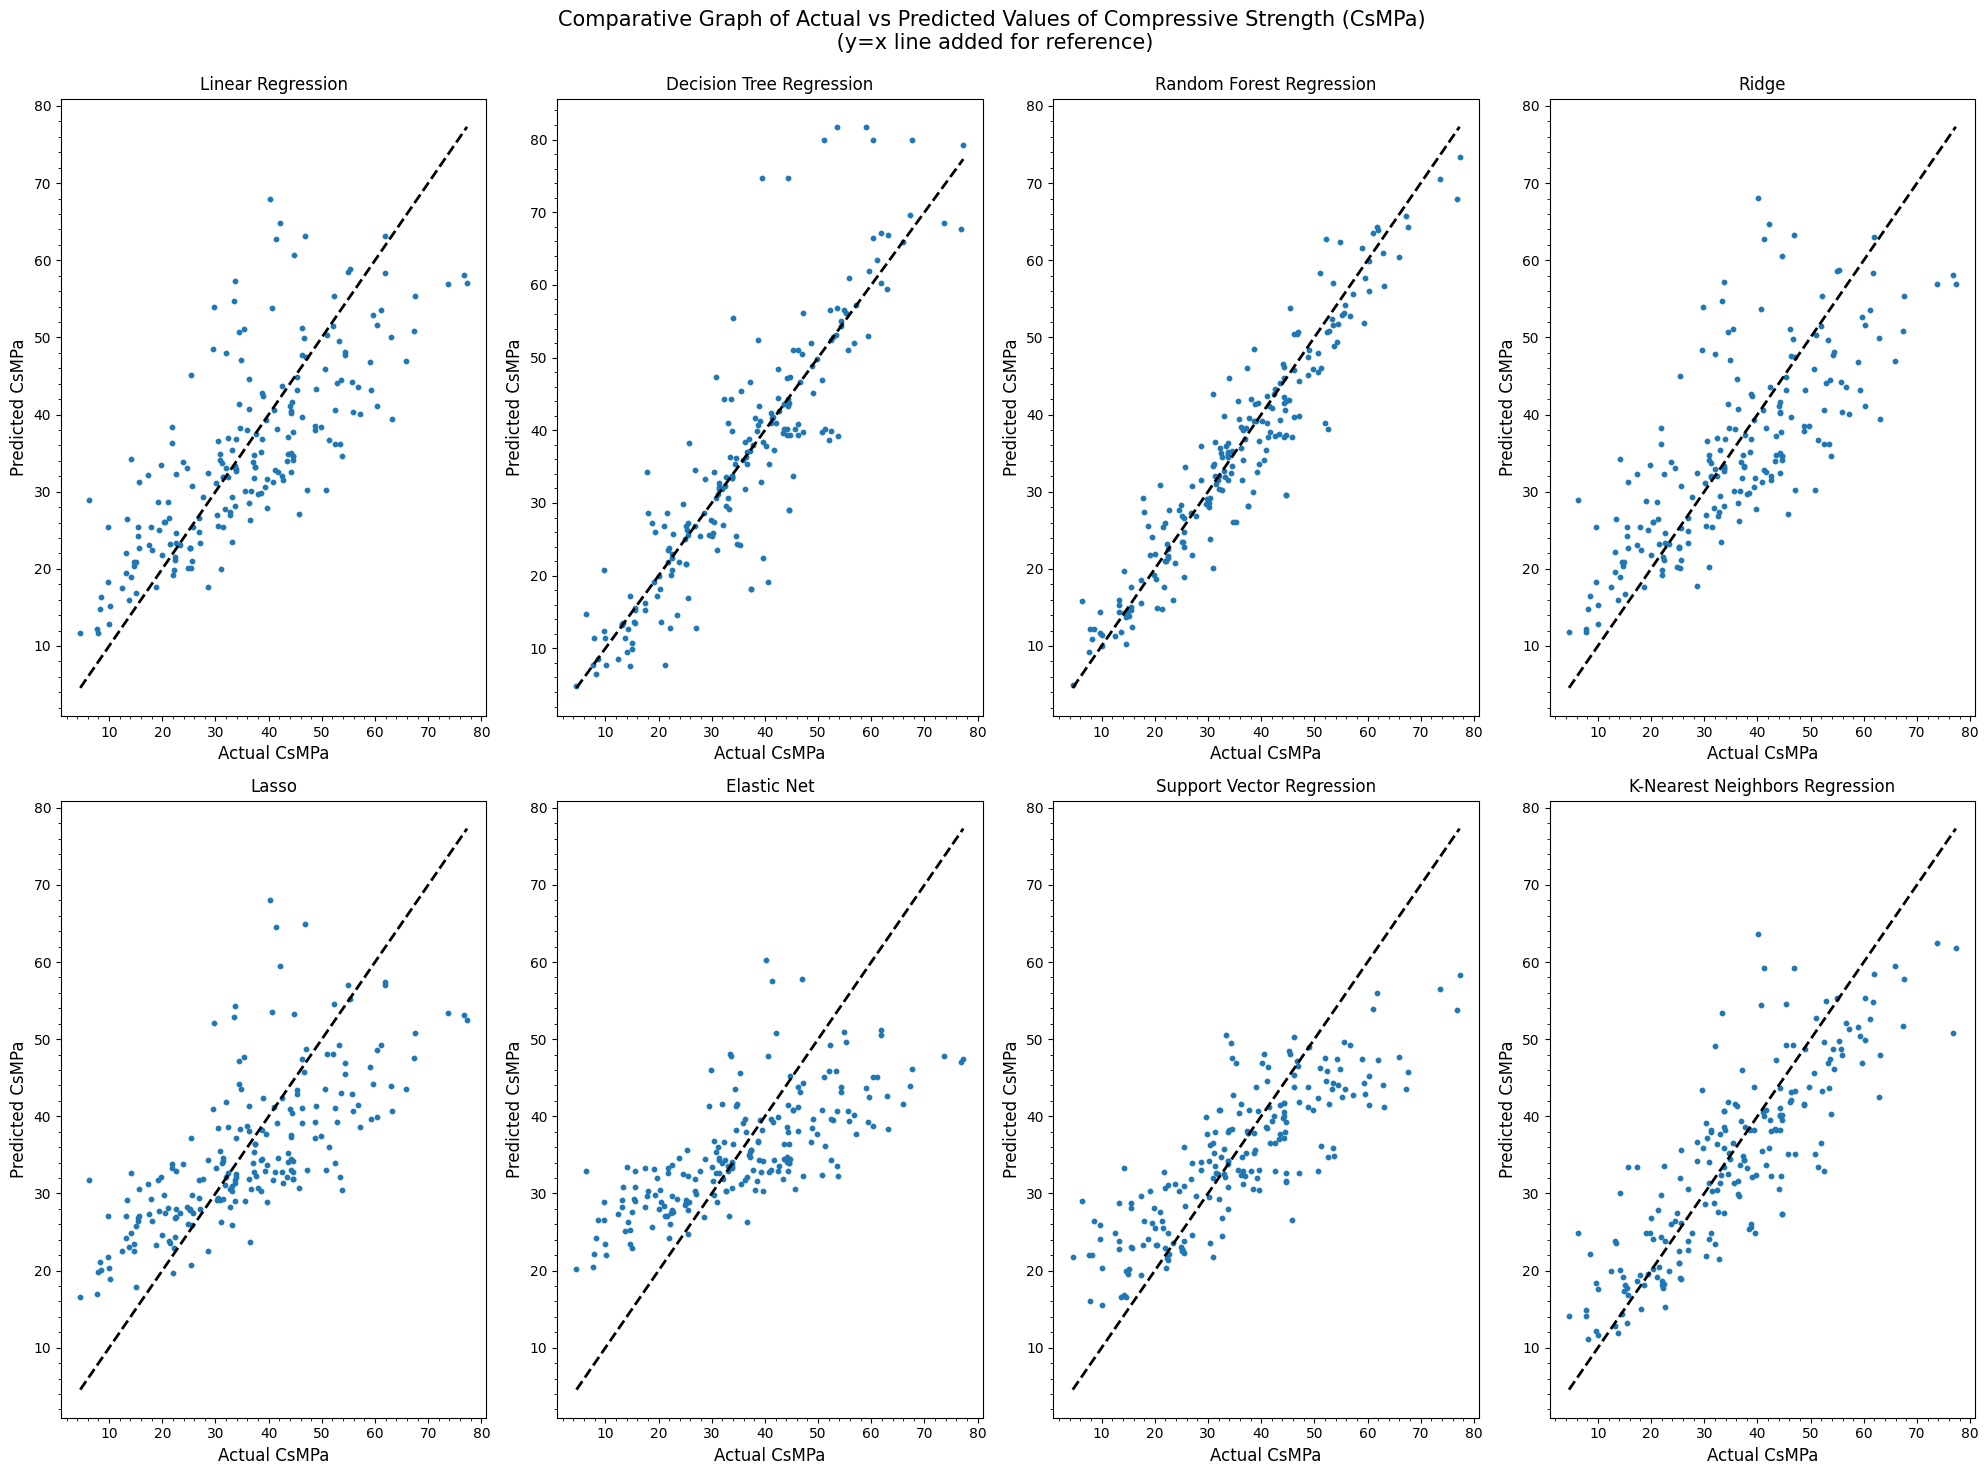

The best model is: Random Forest Regression 

Performing optimisation via randomised & grid search
Optimisation complete: Best parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100} 

Errors are as follows:
Unoptimised RMSE: 4.675561325041829
Optimised RMSE: 4.028698396416294
Unoptimised R^2: 0.9046468821853025
Optimised R^2: 0.929205927850654
Unoptimised MAE: 3.539028977487034
Optimised MAE: 2.952620775800591

Single and double variable impact shown below - See Excel file (variable_drop_impact) for full results:


,Dropped variable: 1,Dropped variable : 2,RMSE,R^2,MAE,RMSE %,R^2 %,MAE %,R^2_rank,RMSE_rank,MAE_rank,rank_sum
5,Fly Ash,,4.076385,0.927520,3.002625,0.986497,1.002159,0.987534,1.0,1.0,2.0,4.0
8,None dropped,,4.132181,0.925522,3.040527,1.000000,1.000000,1.000000,2.0,2.0,5.0,9.0
24,Coarse Aggregate,Fly Ash,4.155290,0.924687,3.060497,1.005592,0.999097,1.006568,3.0,3.0,7.0,13.0
2,Coarse Aggregate,,4.174691,0.923982,3.009009,1.010288,0.998336,0.989634,5.0,5.0,3.0,13.0
3,Superplasticizer,,4.192182,0.923344,2.993341,1.014520,0.997646,0.984481,7.0,7.0,1.0,15.0


Output()

interactive(children=(Dropdown(description='error_type', options=('RMSE', 'R^2', 'MAE'), value='RMSE'), Output…

In [28]:
def main() -> None:
    """ 
    This function calls all the other functions in the script and is used to facilitate the ML pipeline.

    Parameters: None
    Returns: None
    """

    X,y = csv_import() # Call csv_import function to import data
    preprocessing(X,y) # Carrying out preprocessing, dropping duplicates and usng simple mean imputer and standard scaler
    print("Preprocessing done: Standard Scaler, Simple Imputer")

    comp_graph() # Comparing the performance of the different models

    best_model, df = regression_performance() # Identifying the best model, and printing the model name
    print(f"The best model is: {best_model} \n")

    # Hyperparameter optimisation
    print("Performing optimisation via randomised & grid search")
    best_grid_params = random_grid_search()
    print(f"Optimisation complete: Best parameters: {best_grid_params} \n\nErrors are as follows:")
    best_grid_params = opt_unopt_random_forest(best_grid_params)

    # Testing dropping variables from the model
    var_performance(best_grid_params, best_model)
    gVarErrorDf.to_excel('variable_drop_impact.xlsx') #export gVarErrorDf to excel
    var_impact_df = var_impact_pct()

    print("\nSingle and double variable impact shown below - See Excel file (variable_drop_impact) for full results:")
    display(var_impact_df.head(5))

    # Plotting interactive graphs
    var_effect_line() 
    var_effect_bar()
main()

### Function: Final_run()

This function is run to produce the final model, provide error analysis and plot the final learning curve compared to the unoptimised random forrest model.
An interactive histogram of errors is also shown allowing the user to alter bar width (showing a normal distribution line).

Dropped variables: ['flyash']
Final RMSE: 4.073883118408136
Final R^2: 0.9276090106227504
Final MAE: 2.989226952695267


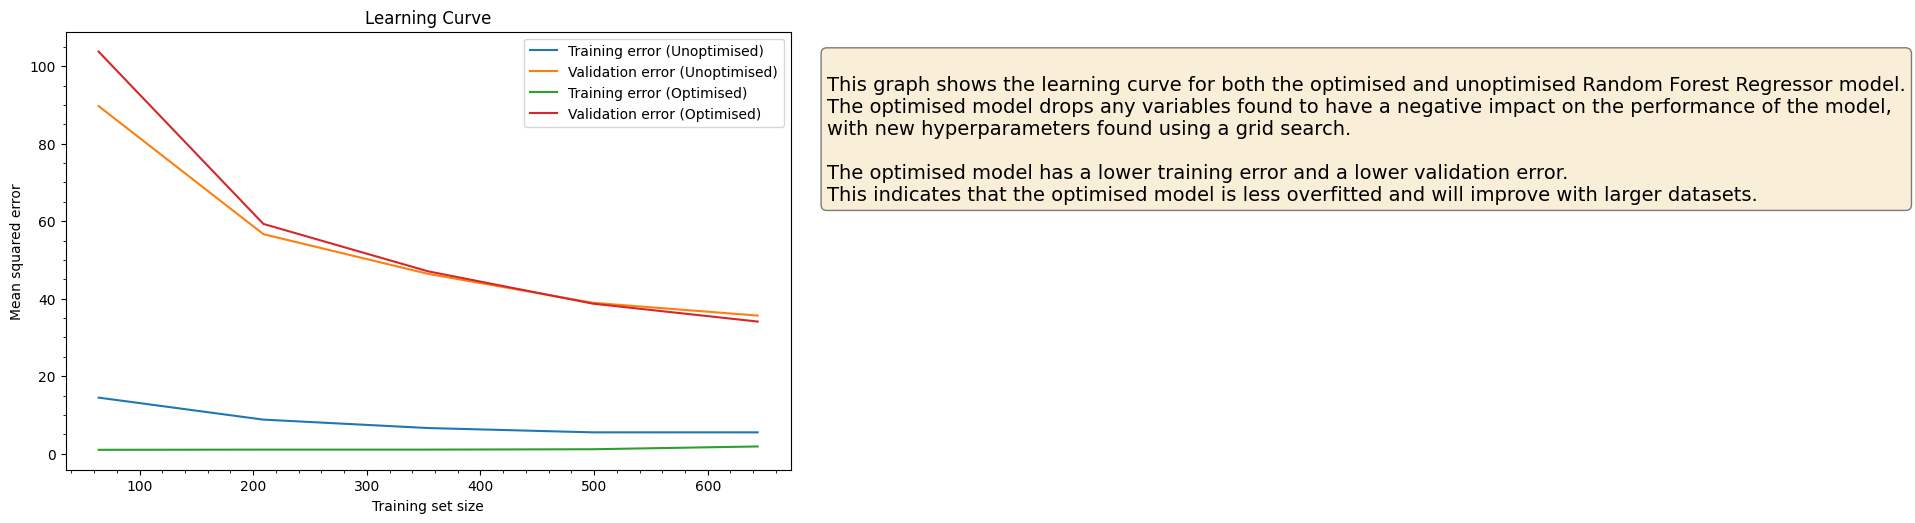

interactive(children=(FloatSlider(value=2.5000000000000004, description='bar_width', max=5.0, min=0.1), Output…

Final model error analysis:
Mean error: 0.71965 CsMPa (5 decimal places)
Standard deviation of errors: 4.00982 CsMPa (5 decimal places)
95% confidence interval of errors: [-6.48073083  9.87543   ] CsMPa
Percentage of predictions that are within 10% of the actual values: 65.35 %


In [29]:
def final_run()-> None:
    """
    This function runs the final model, dropping the variables that have a negative impact on the performance of the model.
    Learning curves are plotted for the final model, and a histogram of the errors is generated.
    The mean error, standard deviation of errors, and 95% confidence interval of errors are calculated.

    Parameters: None
    Returns: None
    """

    X_train_final, X_test_final = var_drop_final() # Variables are dropped based on RMSE ONLY
    final_grid_params, y_pred_final = final_hyperparameters(X_train_final, X_test_final)
    plot_learning_curve(X_train_final, final_grid_params)

    # Create a slider for bar width
    interact(error_histogram, y_pred_final=fixed(y_pred_final), bar_width=(0.1, 5.0, 0.1))
    
    print("Final model error analysis:")
    final_error_analysis(y_pred_final)
final_run()